In [1]:
using StatsBase, Turing, Distributions, Random, MCMCChains, Plots, StatsPlots, Measures, BSON
# Set a random seed for reproducibility
Random.seed!(1234)

TaskLocalRNG()

In [2]:
#Load posteriror samples
BSON.@load "Posterior_Samples/level2_posterior_samples_test1_mixed.bson" posterior_samples_test1_mixed
BSON.@load "Posterior_Samples/level2_posterior_samples_test2_mixed.bson" posterior_samples_test2_mixed
BSON.@load "Posterior_Samples/level2_posterior_samples_test1_uniform.bson" posterior_samples_test1_uniform
BSON.@load "Posterior_Samples/level2_posterior_samples_test2_uniform.bson" posterior_samples_test2_uniform

In [165]:
function compute_posterior_switch_probabilities(
    posterior_samples1, posterior_samples2, utility_LV, utility_HV
)
    # Hardcoded container indices for your use case
    container1_index = 11  # Test 1 corresponds to container 11
    container2_index = 12  # Test 2 corresponds to container 12

    # Get the number of samples in the specified containers
    n_samples = length(posterior_samples1[container1_index][:theta])

    # Ensure both containers have the same number of posterior draws
    if n_samples != length(posterior_samples2[container2_index][:theta])
        error("The number of samples must be the same for both containers.")
    end

    # Initialize arrays to store the posterior distributions of P_Stay and P_Switch
    P_Stay_all = Vector{Vector{Float64}}(undef, n_samples)
    P_Switch_all = Vector{Vector{Float64}}(undef, n_samples)

    # Loop through each sample in the containers
    for i in 1:n_samples
        # Extract posterior samples (vectors) for the current sample
        theta_test1 = posterior_samples1[container1_index][:theta][i]
        theta_test2 = posterior_samples2[container2_index][:theta][i]

        # Ensure both have the same number of posterior draws
        n_draws = length(theta_test1)
        P_Stay_draws = Vector{Float64}(undef, n_draws)
        P_Switch_draws = Vector{Float64}(undef, n_draws)

        # Loop through each posterior draw to compute probabilities
        for j in 1:n_draws
            # Extract the individual posterior draws for theta
            theta1_draw = theta_test1[j]
            theta2_draw = theta_test2[j]

            # Calculate utilities for the current posterior draw
            utility_test1 = exp(theta1_draw * utility_HV + (1 - theta1_draw) * utility_LV)
            utility_test2 = exp(theta2_draw * utility_HV + (1 - theta2_draw) * utility_LV)

            # Compute stay and switch probabilities for this draw
            P_Stay_draws[j] = min(1, utility_test1 / utility_test2)
            P_Switch_draws[j] = 1 - P_Stay_draws[j]
        end

        # Store the posterior distributions for this sample
        P_Stay_all[i] = P_Stay_draws
        P_Switch_all[i] = P_Switch_draws
    end

    return P_Stay_all, P_Switch_all
end

# Example usage with posterior samples
P_Stay_mixed, P_Switch_mixed = compute_posterior_switch_probabilities(
    posterior_samples_test1_mixed,  # Test 1 (container 11)
    posterior_samples_test2_mixed,  # Test 2 (container 12)
    -0.8,  # Utility for low value (LV)
    0.7   # Utility for high value (HV)
)

P_Stay_uniform, P_Switch_uniform = compute_posterior_switch_probabilities(
    posterior_samples_test1_uniform,  # Test 1 (container 11)
    posterior_samples_test2_uniform,  # Test 2 (container 12)
    -0.8,  # Utility for low value (LV)
    0.7   # Utility for high value (HV)
)


([[1.0, 0.9999999885918999, 0.999997835603161, 0.4126733208847635, 1.0, 0.4017040420677887, 1.0, 1.0, 0.7286184214667191, 0.22578454881047558  …  0.9914149623811958, 0.9993726410974744, 1.0, 1.0, 0.9999999641331987, 1.0, 1.0, 1.0, 0.22315666756178573, 1.0], [0.22371072073580056, 0.23509774213523096, 0.22336569833986844, 0.2236782245140332, 1.0, 1.0, 0.22327665318781298, 0.22313017230093932, 0.22314411357105432, 0.22313083220132388  …  0.23692769034769992, 0.24305816181385614, 0.997815332926885, 1.0, 1.0, 1.0, 1.0, 0.9755407698759397, 1.0, 0.31542709499621546], [0.28002147027285523, 0.9179756017048286, 0.6773209975048046, 0.9369500413017815, 0.7355632630369165, 0.7069084109189961, 0.9330663764046703, 0.2380533735433828, 0.22320462494705487, 0.22389947054692091  …  0.9999750972491646, 1.0, 1.0, 1.0, 0.22635316919637902, 0.22314659942061343, 0.22395774471332977, 0.23000278681561198, 0.37434486051141297, 0.23101777670765247], [0.8257851470936115, 0.981181871768486, 0.9590167654492966, 0.90

[ Info: Saved animation to /Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/p_switch_evolution.gif


Plots.AnimatedGif("/Users/aruf650/Library/CloudStorage/OneDrive-Personal/Uni/PhD/Research/Overhypothesis/Analysis/Cognitive_Model/Julia/Models/p_switch_evolution.gif")
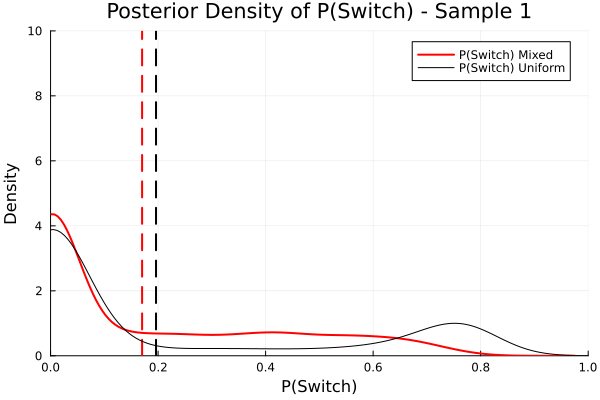

In [193]:
# Function to animate the evolution of P_Switch across samples
function animate_switch_density(P_Switch_mixed, P_Switch_uniform)
    n_samples = length(P_Switch_mixed)  # Total number of samples

    # Create the animation object
    anim = @animate for sample_index in 1:n_samples
        # Extract the posterior distribution for the given sample
        switch_mixed = P_Switch_mixed[sample_index]
        switch_uniform = P_Switch_uniform[sample_index]
    
        # Plot the density of the switch probabilities
        plot(
            switch_mixed, seriestype = :density, xlabel = "P(Switch)",
            ylabel = "Density", title = "Posterior Density of P(Switch) - Sample $sample_index",
            lw = 2, color = :red, xlims = (0, 1), ylims = (0, 10), label = "P(Switch) Mixed"
        )
        # Add a vertical line for the mean of the posterior distribution
        vline!([mean(switch_mixed)], color = :red, linestyle = :dash, lw = 2, label = "")
        density!(switch_uniform, color = :black, label = "P(Switch) Uniform")
        vline!([mean(switch_uniform)], color = :black, linestyle = :dash, lw = 2, label = "")
    end

    # Save the animation as a GIF
    gif(anim, "p_switch_evolution.gif", fps = 1)
end

# Example usage
animate_switch_density(P_Switch_mixed, P_Switch_uniform)


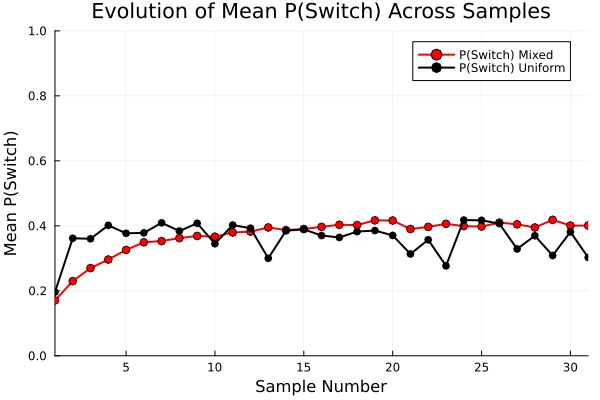

In [195]:
using Plots

# Function to extract the mean P(Switch) for each sample and plot it
function plot_switch_evolution(P_Switch_mixed, P_Switch_uniform)
    n_samples = length(P_Switch_mixed)  # Total number of samples

    # Compute the mean P(Switch) for each sample
    mean_P_Switch_mixed = [mean(P_Switch_mixed[i]) for i in 1:n_samples]
    mean_P_Switch_uniform = [mean(P_Switch_uniform[i]) for i in 1:n_samples]
    
    # Plot the evolution of mean P(Switch) over samples
    plot(
        1:n_samples, mean_P_Switch_mixed, xlabel = "Sample Number", ylabel = "Mean P(Switch)",
        title = "Evolution of Mean P(Switch) Across Samples", lw = 2, marker = :o, color = :red,
        ylims = (0, 1), xlims = (1, 31), label = "P(Switch) Mixed"
    )
    # Overlay the evolution of mean P(Switch) for mixed in green
    plot!(
        1:n_samples, mean_P_Switch_uniform, lw = 2, marker = :o, color = :black, label = "P(Switch) Uniform"
    )
    
end

# Example usage
plot_switch_evolution(P_Switch_mixed, P_Switch_uniform)
